In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc

import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils as np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

import random
import os
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
root_path = "/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset"
path_img_ok = root_path + "/Images/OK/"
path_img_ko = root_path + "/Images/NG/"
path_msk_ok = root_path + "/Masks/OK/"
path_msk_ko = root_path + "/Masks/NG/"
print(path_img_ok)
print(path_img_ko)
print(path_msk_ok)
print(path_msk_ko)

/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/OK/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Images/NG/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/OK/
/Users/I559573/Downloads/D2V2.0/D2V_Datasets/ImageSamples/lgp_dataset/Masks/NG/


In [3]:
def print_random_images(img_folder):
    for i in range(5):
        lst = os.listdir(img_folder)
        lst.sort()
        file = lst[i]
        image_path = os.path.join(img_folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i+1)
        ax.title.set_text(file)
        plt.imshow(img)

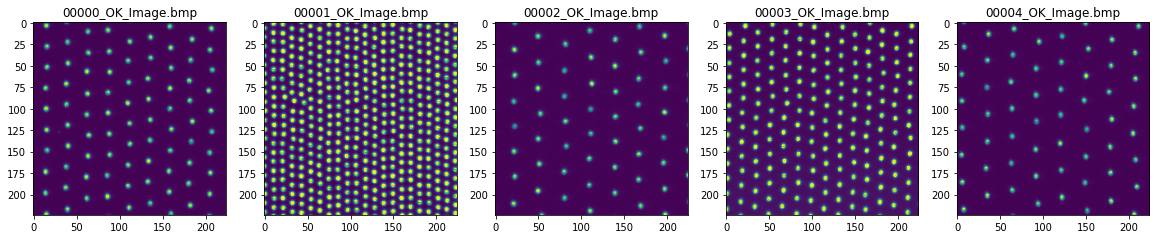

In [4]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ok)

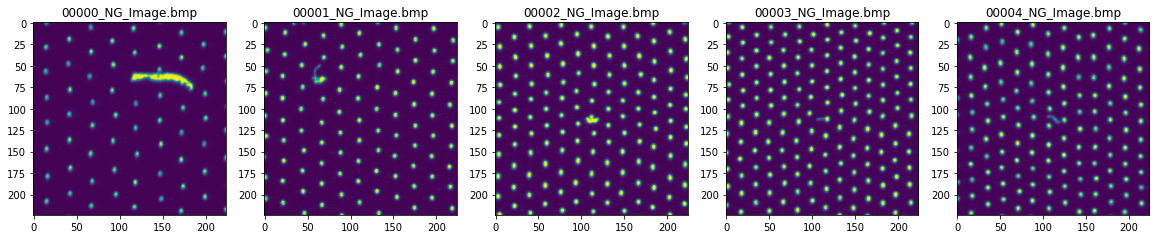

In [5]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ko)

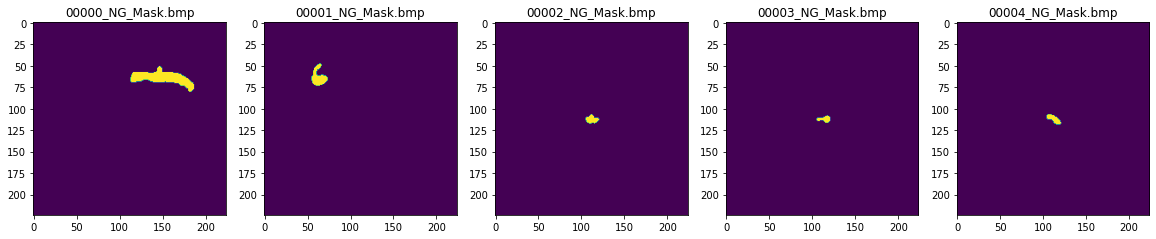

In [6]:
plt.figure(figsize = (20, 20))
print_random_images(path_msk_ko)

In [7]:
img_dataset_ok = []
img_dataset_ko = []
msk_dataset_ok = []
msk_dataset_ko = []

In [8]:
IMG_WIDTH=224
IMG_HEIGHT=224

def create_dataset(img_folder):
    img_data_array = []
    for file in os.listdir(img_folder):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            img_data_array.append(image)
    return img_data_array

def create_dataset_bin(img_folder):
    img_data_array = []
    for file in os.listdir(img_folder):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = image.tobytes()
            img_data_array.append(image)
    return img_data_array

In [9]:
# extract the image array and class name
img_dataset_ok = create_dataset(path_img_ok)
img_dataset_ko = create_dataset(path_img_ko)
msk_dataset_ok = create_dataset(path_msk_ok)
msk_dataset_ko = create_dataset(path_msk_ko)

img_dataset_ok_bin = create_dataset_bin(path_img_ok)
img_dataset_ko_bin = create_dataset_bin(path_img_ko)
msk_dataset_ok_bin = create_dataset_bin(path_msk_ok)
msk_dataset_ko_bin = create_dataset_bin(path_msk_ko)

In [10]:
print(len(img_dataset_ok))
print(len(img_dataset_ko))
print(len(msk_dataset_ok))
print(len(msk_dataset_ko))

print(len(img_dataset_ok_bin))
print(len(img_dataset_ko_bin))
print(len(msk_dataset_ok_bin))
print(len(msk_dataset_ko_bin))

400
422
400
422
400
422
400
422


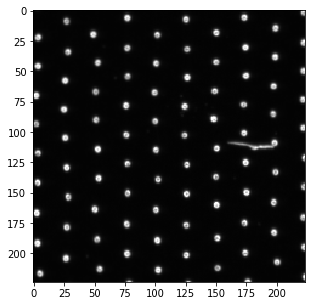

In [11]:
plt.figure(figsize = (5, 5))
plt.imshow(img_dataset_ko[0], interpolation='nearest')

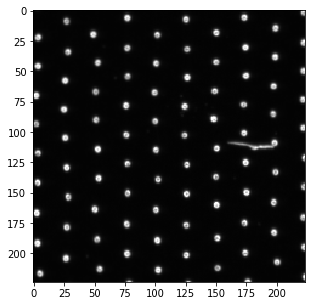

In [12]:
plt.figure(figsize = (5, 5))
img = np.frombuffer(img_dataset_ko_bin[0], dtype=np.float32)
img = np.reshape(img, (224,224,3))
plt.imshow(img, interpolation='nearest')

In [13]:
df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ok['image'] = img_dataset_ok_bin
df_img_dataset_ok['label'] = 0
#df_img_dataset_ok

In [14]:
df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ko['image'] = img_dataset_ko_bin
df_img_dataset_ko['label'] = 1
#df_img_dataset_ko

In [15]:
df_msk_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_msk_dataset_ok['image'] = msk_dataset_ok_bin
df_msk_dataset_ok['label'] = 0
#df_msk_dataset_ok

In [16]:
df_msk_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_msk_dataset_ko['image'] = msk_dataset_ko_bin
df_msk_dataset_ko['label'] = 1
#df_msk_dataset_ok

In [17]:
df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)

In [18]:
#df_img_dataset_tot

In [19]:
#df_msk_dataset_tot

In [20]:
df_img_dataset_tot = df_img_dataset_tot.sample(frac=1).reset_index(drop=True)
df_msk_dataset_tot = df_msk_dataset_tot.sample(frac=1).reset_index(drop=True)

In [21]:
#df_img_dataset_tot

In [22]:
#df_msk_dataset_tot

In [23]:
df_img_dataset_train, df_img_dataset_test = train_test_split(df_img_dataset_tot, test_size=0.97, random_state=25)

In [24]:
df_img_dataset_val, df_img_dataset_test = train_test_split(df_img_dataset_test, test_size=0.97, random_state=25)

In [25]:
df_img_dataset_train.groupby("label")['image'].count()

label
0    12
1    12
Name: image, dtype: int64

In [26]:
df_img_dataset_test.groupby("label")['image'].count()

label
0    378
1    397
Name: image, dtype: int64

In [27]:
df_img_dataset_val.groupby("label")['image'].count()

label
0    10
1    13
Name: image, dtype: int64

In [28]:
print(f"No. of training examples: {df_img_dataset_train.shape[0]}")
print(f"No. of testing examples: {df_img_dataset_test.shape[0]}")
print(f"No. of validation examples: {df_img_dataset_val.shape[0]}")

No. of training examples: 24
No. of testing examples: 775
No. of validation examples: 23


In [29]:
def convert_back(df):
    temp_arr = []
    for i in df['image'].values:
        a = np.frombuffer(i, dtype=np.float32)
        a = a.reshape(224,224,3)
        temp_arr.append(a)
        #print(a.shape)
    return temp_arr

img_train = convert_back(df_img_dataset_train)
img_test = convert_back(df_img_dataset_test)
img_val = convert_back(df_img_dataset_val)
print(len(img_train))
print(len(img_test))
print(len(img_val))
print(img_train[0].shape)
print(img_test[0].shape)
print(img_val[0].shape)

24
775
23
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=(224,224,1)))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

In [30]:
#model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

#base_model = tf.keras.applications.vgg16.VGG16(
#    include_top=True, weights='imagenet', input_tensor=None,
#    input_shape=None, pooling=None, classes=2,
#    classifier_activation='softmax'
#)

base_model = tf.keras.applications.vgg16.VGG16(
    input_shape = (224, 224, 3), # Shape of our images
    include_top = False, # Leave out the last fully connected layer
    weights = 'imagenet'
)

#vgg16.compile(loss=keras.losses.sparse_categorical_crossentropy,
#              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])

2022-02-09 18:02:51.986647: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
for layer in base_model.layers:
    #print(layer.name)
    if(layer.name == 'block4_conv1'):
        break
    else:
        layer.trainable = False

In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
#x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              loss = 'binary_crossentropy', 
              metrics = ['accuracy']
             )

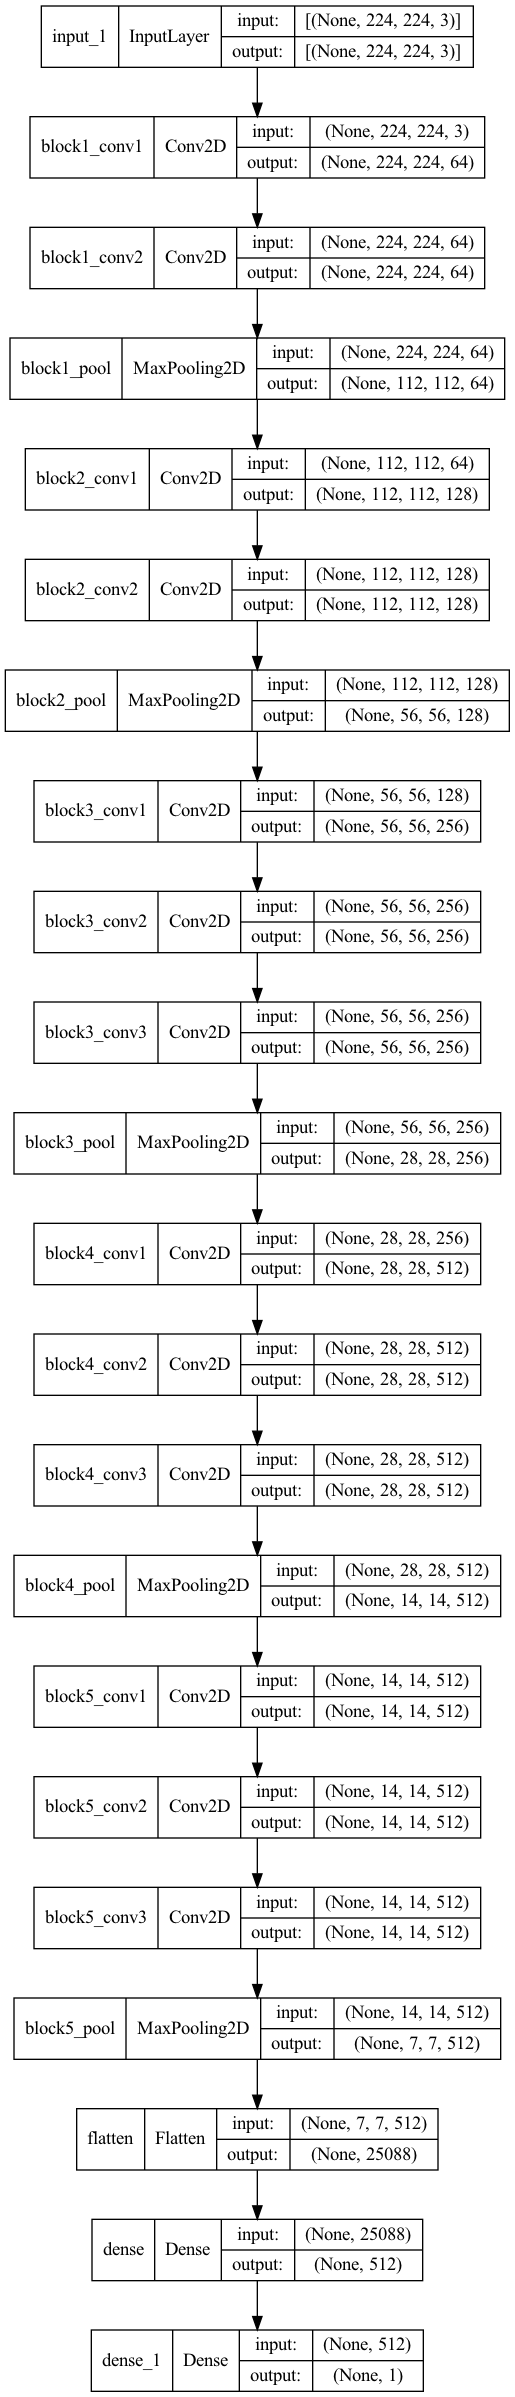

In [35]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
# Define the Keras TensorBoard callback.
import datetime
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
#history = vgg16.fit(x=np.array(img_train, np.float32), 
#                    y=np.array(list(map(int,df_img_dataset_train['label'])), np.float32), epochs=20
#                    ,validation_data=(np.array(img_val, np.float32), df_img_dataset_val['label'].values)
#                   )

history = model.fit(x=np.array(img_train, np.float32), 
                    y=np.array(list(map(int,df_img_dataset_train['label'])), np.float32), 
                    validation_data = (np.array(img_val, np.float32), df_img_dataset_val['label'].values), 
                    #steps_per_epoch = 100, 
                    epochs = 20, callbacks=[tensorboard_callback]
                   )

Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 0.5468 - accuracy: 0.7917 - val_loss: 0.7138 - val_accuracy: 0.5652
Epoch 2/20
1/1 [==============================] - 22s 22s/step - loss: 0.5075 - accuracy: 0.7500 - val_loss: 0.7104 - val_accuracy: 0.5217
Epoch 3/20
1/1 [==============================] - 24s 24s/step - loss: 0.4826 - accuracy: 0.8333 - val_loss: 0.7275 - val_accuracy: 0.5652
Epoch 4/20
1/1 [==============================] - 23s 23s/step - loss: 0.4596 - accuracy: 0.7500 - val_loss: 0.7295 - val_accuracy: 0.5217
Epoch 5/20
1/1 [==============================] - 20s 20s/step - loss: 0.4483 - accuracy: 0.7917 - val_loss: 0.7565 - val_accuracy: 0.5652
Epoch 6/20
1/1 [==============================] - 19s 19s/step - loss: 0.4430 - accuracy: 0.8333 - val_loss: 0.7532 - val_accuracy: 0.5217
Epoch 7/20
1/1 [==============================] - 19s 19s/step - loss: 0.4262 - accuracy: 0.7917 - val_loss: 0.7333 - val_accuracy: 0.5652
Epoch 8/20
1/1 [===========

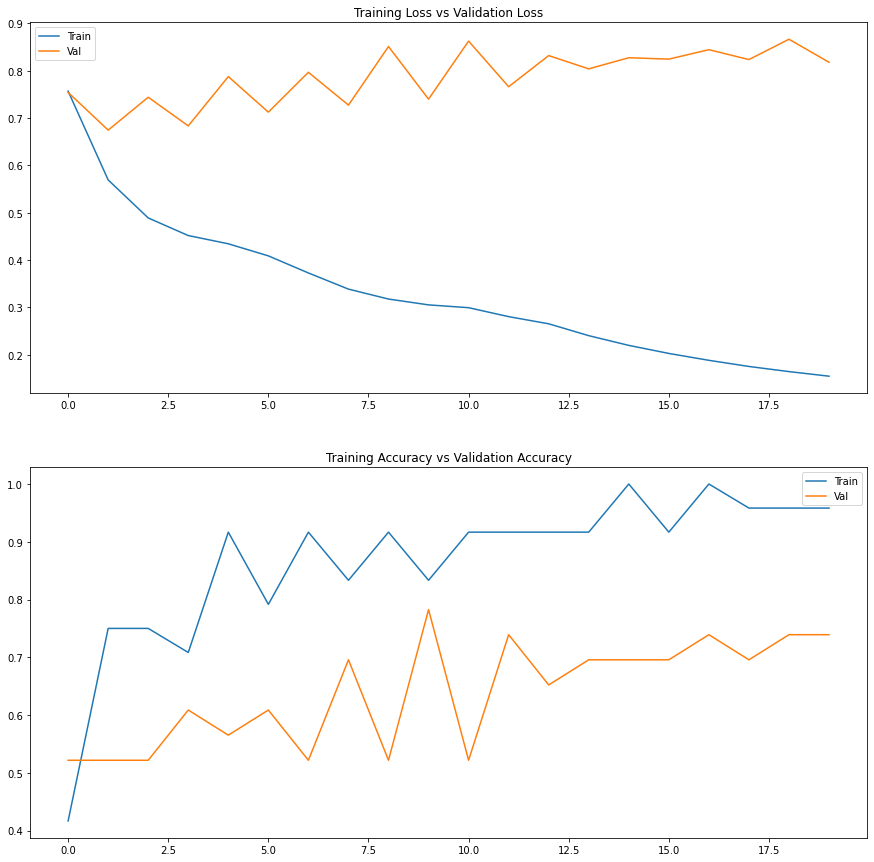

In [144]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [146]:
score = model.evaluate(np.array(img_test, np.float32), df_img_dataset_test['label'].values)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 [==============================] - 259s 10s/step - loss: 1.0865 - accuracy: 0.5935
Test loss: 1.08652925491333
Test accuracy: 0.5935483574867249


In [156]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [163]:
y_pred = np.round(model.predict(np.array(img_val, np.float32)), 0)

Normalized confusion matrix


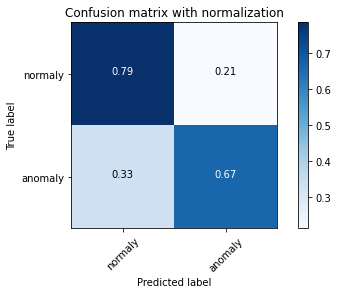

In [165]:
cnf_matrix = confusion_matrix(df_img_dataset_val['label'].astype(int), y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix with normalization')

In [36]:
load_ext tensorboard

In [44]:
tensorboard --logdir logs/fit